[src](https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0)

### FrozenLake
* 4x4 
* The catch is that there is a wind which occasionally blows the agent onto a space they didn’t choose
* 4 actions (4 directions)
* Q-table of 16x4

### Bellman eqn
* $Q(s,a) = r + \gamma(max(Q(s',a'))$

In [1]:
import gym
import numpy as np


In [2]:
env = gym.make('FrozenLake-v0')


[2017-10-23 11:01:05,836] Making new env: FrozenLake-v0


In [3]:
env.observation_space.n

16

In [4]:
env.action_space.n

4

In [7]:
np.random.randn(1,env.action_space.n)*(1./(100+1))

array([[-0.01199847, -0.0064277 ,  0.00405964,  0.00237   ]])

In [8]:
Q = np.zeros([env.observation_space.n,env.action_space.n])
# Set learning parameters
lr = .8
y = .95
num_episodes = 2000
#create lists to contain total rewards and steps per episode
#jList = []
rList = []
for i in range(num_episodes):
    #Reset environment and get first new observation
    s = env.reset()
    rAll = 0
    d = False
    j = 0
    #The Q-Table learning algorithm
    while j < 99:
        j+=1
        #Choose an action by greedily (with noise) picking from Q table
        a = np.argmax(Q[s,:] + np.random.randn(1,env.action_space.n)*(1./(i+1))) # epsilon greedy
        #Get new state and reward from environment
        s1,r,d,_ = env.step(a)
        #Update Q-Table with new knowledge
        Q[s,a] = Q[s,a] + lr*(r + y*np.max(Q[s1,:]) - Q[s,a])
        rAll += r
        s = s1
        if d == True:
            break
    #jList.append(j)
    rList.append(rAll)

In [9]:
Q

array([[  3.60889049e-01,   5.80703927e-03,   4.09406470e-03,
          5.74814794e-03],
       [  2.06110488e-04,   2.33627050e-04,   1.84716183e-03,
          4.59333106e-01],
       [  1.08606075e-01,   1.88887855e-03,   1.94576863e-03,
          2.18870478e-03],
       [  4.03890295e-04,   9.48571838e-05,   4.00070039e-04,
          2.10666068e-03],
       [  4.20603107e-01,   1.13087993e-03,   2.39382649e-03,
          5.90925656e-04],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  4.57940125e-02,   3.42797077e-05,   4.31772693e-04,
          4.02893916e-08],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  1.77033655e-03,   1.65912057e-03,   2.98288121e-04,
          4.95602981e-01],
       [  0.00000000e+00,   6.84887845e-01,   0.00000000e+00,
          9.39371633e-04],
       [  3.26202715e-01,   1.05546836e-03,   1.50359016e-04,
          7.97873022e-04],
       [  0.00000000e

In [10]:
print "Score over time: " +  str(sum(rList)/num_episodes)


Score over time: 0.5255


### Learning via GD
* $\sum (Q_{target} - Q)^2$

In [11]:
import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
env = gym.make('FrozenLake-v0')
print env.action_space.sample()
print env.reset()

[2017-10-23 11:10:40,700] Making new env: FrozenLake-v0


3
0


In [34]:
tf.reset_default_graph()


In [35]:
#These lines establish the feed-forward part of the network used to choose actions
inputs1 = tf.placeholder(shape=[1,16],dtype=tf.float32)
W = tf.Variable(tf.random_uniform([16,4],0,0.01))
Qout = tf.matmul(inputs1,W)
predict = tf.argmax(Qout,1)

#Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
nextQ = tf.placeholder(shape=[1,4],dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

In [36]:
init = tf.initialize_all_variables()

# Set learning parameters
y = .99
e = 0.1
num_episodes = 2000
#create lists to contain total rewards and steps per episode
jList = []
rList = []
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        #Reset environment and get first new observation
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        #The Q-Network
        while j < 99:
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            a,allQ = sess.run([predict,Qout],feed_dict={inputs1:np.identity(16)[s:s+1]})
            if np.random.rand(1) < e:
                a[0] = env.action_space.sample()
            #Get new state and reward from environment
            s1,r,d,_ = env.step(a[0])
            #Obtain the Q' values by feeding the new state through our network
            Q1 = sess.run(Qout,feed_dict={inputs1:np.identity(16)[s1:s1+1]})
            #Obtain maxQ' and set our target value for chosen action.
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0,a[0]] = r + y*maxQ1
            #Train our network using target and predicted Q values
            _,W1 = sess.run([updateModel,W],feed_dict={inputs1:np.identity(16)[s:s+1],nextQ:targetQ})
            rAll += r
            s = s1
            if d == True:
                #Reduce chance of random action as we train the model.
                e = 1./((i/50) + 10)
                break
        jList.append(j)
        rList.append(rAll)
print "Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%"

Instructions for updating:
Use `tf.global_variables_initializer` instead.


[2017-10-23 11:16:11,824] From <ipython-input-36-d370bb19644a>:1: initialize_all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


Percent of succesful episodes: 0.137%


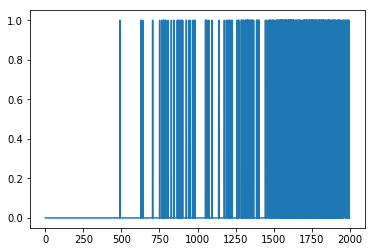

In [37]:
plt.plot(rList)


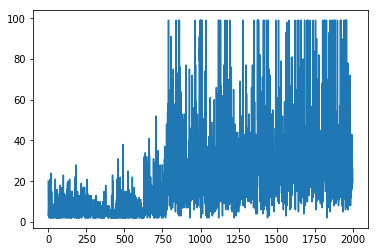

In [38]:
plt.plot(jList)